<a href="https://colab.research.google.com/github/gurnoor6/opponent-modelling/blob/main/LC0_Opponent_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
os.listdir('/content/drive/MyDrive/rbc')

['trout_logs.tar.gz',
 'lczero-training',
 'train.zip',
 'validation.zip',
 'train',
 '__MACOSX',
 'validation']

In [25]:
import shutil
import os
import numpy as np

# keep the logs unzipped in a folder in drive itself
# enter path to that folder in log_files_path
# no need to unzip everytime
log_files_path = '/content/drive/MyDrive/rbc'
os.chdir(log_files_path)
train_set = 'train'
train_filenames = os.listdir(train_set)
print(len(os.listdir(train_set)))

validation_set = 'validation'
validation_filenames = os.listdir(validation_set)
print(len(os.listdir(validation_set)))

10000
989


In [26]:
# import shutil, os
# zip_file_name = "lczero-training-5.zip"
# # if os.path.exists("lczero-training"):
# #   shutil.rmtree("lczero-training")
# shutil.unpack_archive(zip_file_name)

In [27]:
# keep lczero-training unzipped in a folder in drive
# use that instead of unzipping everytime
import shutil, os
os.chdir("/content/drive/MyDrive/rbc/lczero-training/tf")
print(os.listdir())

['lc0_az_policy_map.py', 'train.py', 'model_to_net.py', 'shufflebuffer.py', 'net.pb.cc', 'net_to_model.py', 'start.sh', 'TK-6430 aka 128x10-BPR-64M-6430000.pb.gz', 'net.pb.h', 'details_from_weights_file.py', 'requirements.txt', 'tfprocess.py', 'net.py', 'chunkparsefunc.py', 'net.proto', 'model_plot.png', 'attention_policy_map.py', 'chunkparser.py', 'update_steps.py', 'make_model.py', 'policy_index.py', 'decode_training.py', 'net_pb2.py', 'loading_lc0.ipynb', 'weights_run2_790389.pb.gz', 'leelalogs', 'configs', '__pycache__', 'LC0_Opponent_Modelling.ipynb']


In [28]:
weights_file_name = "TK-6430 aka 128x10-BPR-64M-6430000"

In [29]:
import yaml
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

from tfprocess import TFProcess
if os.path.exists(f"configs/{weights_file_name}.yaml"):
  print(yaml.safe_load(open(f"configs/{weights_file_name}.yaml").read())['model'])
  tfprocess = TFProcess(yaml.safe_load(open(f"configs/{weights_file_name}.yaml").read()))
else:
  print(yaml.safe_load(open(f"configs/example.yaml").read()))
  tfprocess = TFProcess(yaml.safe_load(open(f"configs/example.yaml").read())['model'])
tfprocess.init_net()
tfprocess.replace_weights(f"{weights_file_name}.pb.gz")

{'filters': 128, 'residual_blocks': 10, 'se_ratio': 4, 'policy': 'convolution', 'pol_embedding_size': 64, 'pol_encoder_layers': 0, 'pol_encoder_heads': 0, 'pol_encoder_d_model': 32, 'pol_encoder_dff': 128, 'policy_d_model': 64, 'value': 'wdl', 'moves_left': 'none'}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Blocks: 10
Filters: 128
pblczero.Net.magic: 448
pblczero.Net.license: 
pblczero.EngineVersion.major: 0
pblczero.EngineVersion.minor: 21
pblczero.EngineVersion.patch: 0
pblczero.Format.weights_encoding: LINEAR16
pblczero.NetworkFormat.input: INPUT_CLASSICAL_112_PLANE
pblczero.NetworkFormat.output: OUTPUT_WDL
pblczero.NetworkFormat.network: NETWORK_SE_WITH_HEADFORMAT
pblczero.NetworkFormat.policy: POLICY_CONVOLUTION
pblczero.NetworkFormat.value: VALUE_WDL
pblczero.NetworkFormat.moves_left: MOVES_LEFT_NONE
pblczero.NetworkFormat.default_activation: DEFAULT_ACTIVATION_RELU
pblczero.TrainingParams.training_steps: 6430000
pblczero

In [30]:
print(tfprocess.model.input)
print(tfprocess.model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 112, 8, 8), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1858), dtype=tf.float32, name=None), name='apply_policy_map_1/MatMul:0', description="created by layer 'apply_policy_map_1'")


In [31]:
import numpy as np

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, filenames, batch_size, randomize, folder_name) :
    self.filenames = filenames
    self.batch_size = batch_size
    self.randomize = randomize
    self.folder_name = folder_name
    self.boards_per_game = 6
    
    
  def __len__(self) :
    return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    filenames = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    inputs = []
    outputs = []
    legal_moves = []
    for f in filenames:
      if not f.endswith('.npz'): continue
      loaded = np.load(os.path.join(self.folder_name, f))
      length = len(loaded['inputs'])
      index = np.random.choice(length, length,replace=False)
      if self.randomize:
        index = np.random.choice(length, min(self.boards_per_game, length), replace = False)
      inputs.extend(loaded['inputs'][index])
      outputs.extend(loaded['outputs'][index])
      legal_moves.extend(loaded['legal_moves'][index])
    
    # Y_new = []
    # for item in outputs: Y_new.append(item.flatten())
    
    # print(np.array(inputs).shape, np.array(Y_new).shape)
    return (np.array(inputs), np.array(legal_moves)), np.array(outputs)

In [32]:
batch_size = 32

training_generator = My_Custom_Generator(train_filenames, batch_size, True, train_set)
validation_generator = My_Custom_Generator(validation_filenames, batch_size, False, validation_set)

In [33]:
from keras.utils.vis_utils import plot_model



input_1 = tfprocess.model.input
input_2 = tf.keras.Input(shape = (1858))

# Remove ilegal first then softmax over remaining
outputs = tfprocess.model.output
output_1 = outputs
illegal_filler = tf.zeros_like(output_1) - 1.0e10
output_2 = tf.where(tf.cast(input_2, bool), output_1, illegal_filler)
output_3 = tf.keras.layers.Softmax()(output_2)
# output_3 = tf.keras.layers.Multiply()([input_2, output_2])
# output_3 = tf.where(tf.cast(input_2, bool), output_2, tf.expand_dims(tf.constant(1e-9 * np.ones(1858, dtype = 'float32')), 0))

# output = tf.keras.layers.Lambda(lambda x: tf.math.divide(x, tf.linalg.norm(x, ord=1)))(output_3)
# output = tf.keras.layers.Lambda(lambda x: tf.math.divide(x, tf.math.reduce_sum(x)))(output_3)

model = tf.keras.Model(inputs = [input_1, input_2], outputs = output_3)
# model = tf.keras.Model(inputs = input_1, outputs = output_1)
model.summary()
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 8, 8)]  0           []                               
                                                                                                  
 input/conv2d (Conv2D)          (None, 128, 8, 8)    129024      ['input_3[0][0]']                
                                                                                                  
 input/bn (BatchNormalization)  (None, 128, 8, 8)    512         ['input/conv2d[0][0]']           
                                                                                                  
 activation_33 (Activation)     (None, 128, 8, 8)    0           ['input/bn[0][0]']               
                                                                                            

In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
print("Device Name =", device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Device Name = /device:GPU:0
Found GPU at: /device:GPU:0


In [35]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [36]:
os.chdir("/content/drive/MyDrive/rbc") # nullify effect of previous chdir

In [37]:
# inputs = []
# legal_moves = []
# outputs = []
# for f in os.listdir(train_set)[:1000]:
#   if not f.endswith('.npz'): continue
#   loaded = np.load(os.path.join(train_set, f))
#   length = len(loaded['inputs'])
#   index = np.random.choice(length, length,replace=False)
#   inputs.extend(loaded['inputs'][index])
#   outputs.extend(loaded['outputs'][index])
#   legal_moves.extend(loaded['legal_moves'][index])

# inputs = np.array(inputs)
# outputs = np.array(outputs)
# legal_moves = np.array(legal_moves)
# np.expand_dims(inputs, axis = 0)
# np.expand_dims(outputs, axis = 0)
# np.expand_dims(legal_moves, axis = 0)
# print(inputs.shape, outputs.shape, legal_moves.shape)

In [38]:
# validation_inputs = []
# validation_legal_moves = []
# validation_outputs = []
# for f in os.listdir(validation_set)[:1000]:
#   if not f.endswith('.npz'): continue
#   loaded = np.load(os.path.join(validation_set, f))
#   length = len(loaded['inputs'])
#   index = np.random.choice(length, length,replace=False)
#   validation_inputs.extend(loaded['inputs'][index])
#   validation_outputs.extend(loaded['outputs'][index])
#   validation_legal_moves.extend(loaded['legal_moves'][index])

# validation_inputs = np.array(validation_inputs)
# validation_outputs = np.array(validation_outputs)
# validation_legal_moves = np.array(validation_legal_moves)
# print(validation_inputs.shape, validation_outputs.shape, validation_legal_moves.shape)

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [40]:
is_value_head = False

In [41]:
# stored_outputs = outputs.copy()

In [42]:
# # If lc0 - training - 3 (with value head output)
# value_outputs = None
# if is_value_head:
#   # _value_outputs = model.predict(x = [np.array([inputs]), np.array([legal_moves])])
#   _value_outputs = model.predict(x = [inputs, legal_moves])
#   # model.evaluate(x = [inputs, legal_moves], y = _value_outputs)
#   print(len(_value_outputs))
#   print(_value_outputs[0].shape)
#   print(len(_value_outputs[0]))
#   print(_value_outputs[1].shape)
#   print(len(_value_outputs[1]))

#   _value_outputs[0][0] /= np.sum(_value_outputs[0][0])
#   for i in range(1858):
#     if _value_outputs[0][0][i] > 1e-9:
#       print(i, _value_outputs[0][0][i])

#   value_outputs = np.zeros([len(inputs)])
  
#   value_outputs = _value_outputs[0]
#   print(value_outputs.shape)
#   print(len(outputs))
#   print(stored_outputs.shape)
#   model.evaluate(x = [inputs, legal_moves], y = [stored_outputs, value_outputs])
#   print(_value_outputs[0][0])
#   print(np.sum(inputs[0]))
#   print(stored_outputs[0])
#   print(np.sum(stored_outputs[0]))

  

# else:
#   model.evaluate(x = [inputs, legal_moves], y = stored_outputs)
#   # model.evaluate(x = inputs, y = stored_outputs)

#   k = np.random.choice(len(inputs), min(len(inputs), 3))

#   _value_outputs = model.predict(x = [inputs[k], legal_moves[k]])
#   # _value_outputs = model.predict(x = inputs[k])
#   print(_value_outputs.shape)

#   for i in range(len(k)):
#     index = k[i]
#     # _value_outputs[i] = np.exp(_value_outputs[i])
#     # _value_outputs[i] *= legal_moves[i]
#     _value_outputs[i] /= np.sum(_value_outputs[i])
#     print("index =", index)
#     print("Move with maximum probability returned by model", np.argmax(_value_outputs[i]))
#     print("Probability of that move", np.max(_value_outputs[i]))
#     print("Move decided by player", np.argmax(stored_outputs[i]))
#     print("Probability of that move", np.max(stored_outputs[i]))
#     print("Probability of that move returned by model", _value_outputs[i][np.argmax(stored_outputs[i])])
#     # for j in range(1858):
#     #   if _value_outputs[i][j] > 1e-9:
#     #     print(j, _value_outputs[i][j])
#     print()
    

# del stored_outputs

In [43]:
to_train = True
if not to_train:
  assert(0)

In [44]:
if is_value_head:
  history = model.fit(
    inputs,
    [
      outputs,
      value_outputs
    ],
    epochs = 10,
  )
else:
  # history = model.fit(
  #   [
  #    inputs,
  #    legal_moves
  #   ],
  #   outputs,
  #   validation_data = ((validation_inputs, validation_legal_moves), validation_outputs,),
  #   epochs = 20,
  # )
  history = model.fit_generator(
      generator=training_generator,
      steps_per_epoch = int(len(train_filenames) // batch_size),
      epochs = 20,
      verbose = 1,
      validation_data = validation_generator,
      validation_steps = int(len(validation_filenames) // batch_size)  # Use only 1000 samples for validation
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
312/312 [==============================] - 193s 579ms/step - loss: 259351648.0000 - categorical_accuracy: 0.3108 - val_loss: 226429680.0000 - val_categorical_accuracy: 0.1458
Epoch 2/20
312/312 [==============================] - 165s 530ms/step - loss: 256828256.0000 - categorical_accuracy: 0.2795 - val_loss: 226429680.0000 - val_categorical_accuracy: 0.1077
Epoch 3/20
312/312 [==============================] - 179s 574ms/step - loss: 263019248.0000 - categorical_accuracy: 0.2548 - val_loss: 226429680.0000 - val_categorical_accuracy: 0.1758
Epoch 4/20
312/312 [==============================] - 175s 560ms/step - loss: 260271808.0000 - categorical_accuracy: 0.2458 - val_loss: 226429680.0000 - val_categorical_accuracy: 0.1284
Epoch 5/20
312/312 [==============================] - 171s 548ms/step - loss: 265175232.0000 - categorical_accuracy: 0.2544 - val_loss: 226429680.0000 - val_categorical_accuracy: 0.1668
Epoch 6/20
312/312 [==============================] - 174s 559ms/step 

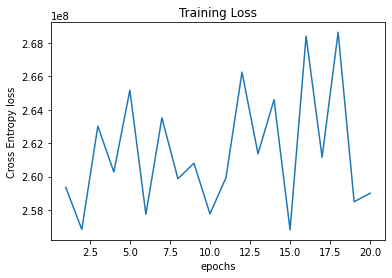

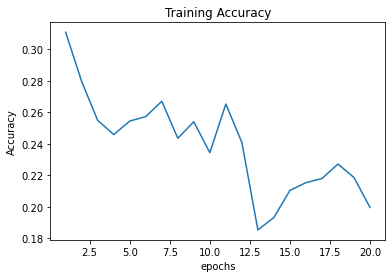

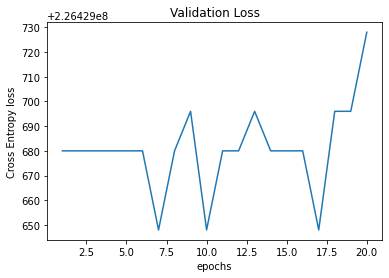

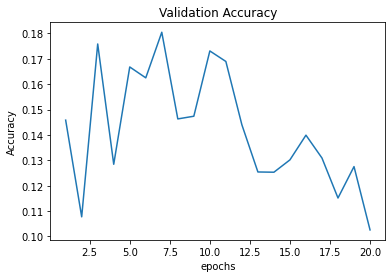

In [45]:
# Plot the loss a sa function of number of epochs
import matplotlib.pyplot as plt

# plt.subplot(2, 2, 1)
plt.figure()
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['loss'])))),  history.history['loss'])

# plt.subplot(2, 2, 2)
plt.figure()
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['categorical_accuracy'])))),  history.history['categorical_accuracy'])

# plt.subplot(2, 2, 3)
plt.figure()
# Plot the loss a sa function of number of epochs
plt.title('Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_loss'])))),  history.history['val_loss'])

# plt.subplot(2, 2, 4)
plt.figure()
plt.title('Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_categorical_accuracy'])))),  history.history['val_categorical_accuracy'])

In [46]:
# Saving Model in lc0 format
# from google.colab import files
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary() # Check that input2, softmax and where layer are removed only. 
tfprocess.model = model
self.save_leelaz_weights('trained_model.pb.gz')
files.download('trained_model.pb.gz')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 8, 8)]  0           []                               
                                                                                                  
 input/conv2d (Conv2D)          (None, 128, 8, 8)    129024      ['input_3[0][0]']                
                                                                                                  
 input/bn (BatchNormalization)  (None, 128, 8, 8)    512         ['input/conv2d[0][0]']           
                                                                                                  
 activation_33 (Activation)     (None, 128, 8, 8)    0           ['input/bn[0][0]']               
                                                                                            

NameError: ignored

In [ ]:
# from google.colab import files

# folder_name = "saved-model"

# if os.path.exists(folder_name):
#   shutil.rmtree(folder_name)
# os.mkdir(folder_name)

# if os.path.exists(folder_name + ".zip"):
#   os.remove(folder_name + ".zip")
# model.save(folder_name)

# shutil.make_archive(folder_name, 'zip', folder_name)
# files.download(folder_name + ".zip") 

# if os.path.exists(folder_name):
#   shutil.rmtree(folder_name)
# os.mkdir(folder_name)


# if os.path.exists(folder_name + ".pb.gz"):
#   os.remove(folder_name + ".pb.gz")
# tfprocess.model = model
# tfprocess.save_leelaz_weights(folder_name)
# files.download(folder_name + ".pb.gz")